# vLife Virtusa

# Medical Appointment NoShow Usecase
#### Usecase Description 
<b>A person makes a doctor appointment, receives all the instructions and no-show. Machine learning Random forest Model is built in order to predict Show/NoShow of patients who makes doctor appointment.</b>
#### Data Source

Data for Medical Appointment NoShow available [here](https://www.kaggle.com/joniarroba/noshowappointments)



#### Dataset Description
 - <b> PatientId </b>
Identification of a patient
 - <b> AppointmentID </b>
Identification of each appointment
 - <b> Gender </b>
Male or Female . Female is the greater proportion, woman takes way more care of they health in comparison to man.
 - <b> DataMarcacaoConsulta </b>
The day of the actuall appointment, when they have to visit the doctor.
 - <b> DataAgendamento </b>
The day someone called or registered the appointment, this is before appointment of course.
 - <b> Age </b>
How old is the patient.
 - <b> Neighbourhood </b>
Where the appointment takes place.
 - <b> Scholarship </b>
True of False . Observation, this is a broad topic, consider reading this article https://en.wikipedia.org/wiki/Bolsa_Fam%C3%ADlia
 - <b> Hipertension </b>
True or False
 - <b> Diabetes </b>
True or False
 - <b> Alcoholism </b>
True or False
 - <b> Handcap </b>
True or False
 - <b> SMS_received </b>
1 or more messages sent to the patient.
 - <b> No-show </b>
True or False.

### Import Neccessary Packages and Libraries

In [1]:
import pandas as pd
import numpy as np
import datetime
from time import strftime
import itertools

from sklearn.metrics import accuracy_score,precision_score,roc_curve,roc_auc_score,classification_report
from sklearn.model_selection import GridSearchCV,KFold,train_test_split,learning_curve
from sklearn.preprocessing import LabelEncoder,StandardScaler,MinMaxScaler
import seaborn as se
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

import keras
from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping


import matplotlib.pyplot as plt
%matplotlib inline
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import plotly.figure_factory as ff
import seaborn as sns
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import ExtraTreeClassifier
from sklearn.linear_model import  RidgeClassifier
from imblearn.over_sampling import ADASYN

Using TensorFlow backend.


In [2]:
data = pd.read_csv('KaggleV2-May-2016.csv')

In [3]:
print("The shape of the DataFrame {}".format(data.shape))

The shape of the DataFrame (110527, 14)


In [4]:
data.head()

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,5.589978e+14,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4.262962e+12,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,8.679512e+11,5642828,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,8.841186e+12,5642494,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,0,0,No


### Exploratary Data Analysis

In [5]:
data['PatientId'] = data['PatientId'].astype('int64')

data['ScheduledDay'] = pd.to_datetime(data['ScheduledDay']).dt.date.astype('datetime64[ns]')
data['AppointmentDay'] = pd.to_datetime(data['AppointmentDay']).dt.date.astype('datetime64[ns]')

data = data.rename(columns={'Hipertension': 'Hypertension', 'Handcap': 'Handicap', 'SMS_received': 'SMSReceived', 'No-show': 'NoShow'})

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110527 entries, 0 to 110526
Data columns (total 14 columns):
PatientId         110527 non-null int64
AppointmentID     110527 non-null int64
Gender            110527 non-null object
ScheduledDay      110527 non-null datetime64[ns]
AppointmentDay    110527 non-null datetime64[ns]
Age               110527 non-null int64
Neighbourhood     110527 non-null object
Scholarship       110527 non-null int64
Hypertension      110527 non-null int64
Diabetes          110527 non-null int64
Alcoholism        110527 non-null int64
Handicap          110527 non-null int64
SMSReceived       110527 non-null int64
NoShow            110527 non-null object
dtypes: datetime64[ns](2), int64(9), object(3)
memory usage: 11.8+ MB


In [7]:
percent_missing = (data.isnull().sum() / len(data)).sort_values(ascending = False)
percent_missing.head()

NoShow         0.0
SMSReceived    0.0
Handicap       0.0
Alcoholism     0.0
Diabetes       0.0
dtype: float64

In [8]:
data.head()

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hypertension,Diabetes,Alcoholism,Handicap,SMSReceived,NoShow
0,29872499824296,5642903,F,2016-04-29,2016-04-29,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,558997776694438,5642503,M,2016-04-29,2016-04-29,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4262962299951,5642549,F,2016-04-29,2016-04-29,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,867951213174,5642828,F,2016-04-29,2016-04-29,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,8841186448183,5642494,F,2016-04-29,2016-04-29,56,JARDIM DA PENHA,0,1,1,0,0,0,No


In [9]:
print(f"Total of Unique Patients is {data.PatientId.nunique()} and Appointments is {data.AppointmentID.nunique()}")

Total of Unique Patients is 62299 and Appointments is 110527


In [10]:
null_feat = pd.DataFrame(len(data['PatientId']) - data.isnull().sum(), columns = ['Count'])

trace = go.Bar(x = null_feat.index, y = null_feat['Count'] ,opacity = 0.8, marker=dict(color = 'lightblue',
        line=dict(color='#000000',width=1.5)))

layout = dict(title =  "Missing Values")
                    
fig = dict(data = [trace], layout=layout)
py.iplot(fig)

In [11]:
# Print Unique Values
print("Unique Values in `Gender` => {}".format(data.Gender.unique()))
print("Unique Values in `Scholarship` => {}".format(data.Scholarship.unique()))
print("Unique Values in `Hypertension` => {}".format(data.Hypertension.unique()))
print("Unique Values in `Diabetes` => {}".format(data.Diabetes.unique()))
print("Unique Values in `Alcoholism` => {}".format(data.Alcoholism.unique()))
print("Unique Values in `Handicap` => {}".format(data.Handicap.unique()))
print("Unique Values in `SMSReceived` => {}".format(data.SMSReceived.unique()))

Unique Values in `Gender` => ['F' 'M']
Unique Values in `Scholarship` => [0 1]
Unique Values in `Hypertension` => [1 0]
Unique Values in `Diabetes` => [0 1]
Unique Values in `Alcoholism` => [0 1]
Unique Values in `Handicap` => [0 1 2 3 4]
Unique Values in `SMSReceived` => [0 1]


In [12]:
data['Scholarship'] = data['Scholarship'].astype('object')
data['Hypertension'] = data['Hypertension'].astype('object')
data['Diabetes'] = data['Diabetes'].astype('object')
data['Alcoholism'] = data['Alcoholism'].astype('object')
data['Handicap'] = data['Handicap'].astype('object')
data['SMSReceived'] = data['SMSReceived'].astype('object')

In [13]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110527 entries, 0 to 110526
Data columns (total 14 columns):
PatientId         110527 non-null int64
AppointmentID     110527 non-null int64
Gender            110527 non-null object
ScheduledDay      110527 non-null datetime64[ns]
AppointmentDay    110527 non-null datetime64[ns]
Age               110527 non-null int64
Neighbourhood     110527 non-null object
Scholarship       110527 non-null object
Hypertension      110527 non-null object
Diabetes          110527 non-null object
Alcoholism        110527 non-null object
Handicap          110527 non-null object
SMSReceived       110527 non-null object
NoShow            110527 non-null object
dtypes: datetime64[ns](2), int64(3), object(9)
memory usage: 11.8+ MB


In [14]:
print("Patients with `Age` less than -1 - {}".format(data[data.Age == -1].shape[0]))

Patients with `Age` less than -1 - 1


In [15]:
data = data[(data.Age >= 0 ) & (data.Age <= 100)]
print("Unique Values in `Age` => {}".format(np.sort(data.Age.unique())))

Unique Values in `Age` => [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100]


In [16]:
# Get Day of the Week for ScheduledDay and AppointmentDay
data['ScheduledDay_DOW'] = data['ScheduledDay'].dt.weekday_name
data['AppointmentDay_DOW'] = data['AppointmentDay'].dt.weekday_name

In [17]:
data['AppointmentDay'] = np.where((data['AppointmentDay'] - data['ScheduledDay']).dt.days < 0, data['ScheduledDay'], data['AppointmentDay'])

# Get the Waiting Time in Days of the Patients.
data['Waiting_Time_days'] = data['AppointmentDay'] - data['ScheduledDay']
data['Waiting_Time_days'] = data['Waiting_Time_days'].dt.days

In [18]:
data

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hypertension,Diabetes,Alcoholism,Handicap,SMSReceived,NoShow,ScheduledDay_DOW,AppointmentDay_DOW,Waiting_Time_days
0,29872499824296,5642903,F,2016-04-29,2016-04-29,62,JARDIM DA PENHA,0,1,0,0,0,0,No,Friday,Friday,0
1,558997776694438,5642503,M,2016-04-29,2016-04-29,56,JARDIM DA PENHA,0,0,0,0,0,0,No,Friday,Friday,0
2,4262962299951,5642549,F,2016-04-29,2016-04-29,62,MATA DA PRAIA,0,0,0,0,0,0,No,Friday,Friday,0
3,867951213174,5642828,F,2016-04-29,2016-04-29,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No,Friday,Friday,0
4,8841186448183,5642494,F,2016-04-29,2016-04-29,56,JARDIM DA PENHA,0,1,1,0,0,0,No,Friday,Friday,0
5,95985133231274,5626772,F,2016-04-27,2016-04-29,76,REPÚBLICA,0,1,0,0,0,0,No,Wednesday,Friday,2
6,733688164476661,5630279,F,2016-04-27,2016-04-29,23,GOIABEIRAS,0,0,0,0,0,0,Yes,Wednesday,Friday,2
7,3449833394123,5630575,F,2016-04-27,2016-04-29,39,GOIABEIRAS,0,0,0,0,0,0,Yes,Wednesday,Friday,2
8,56394729949972,5638447,F,2016-04-29,2016-04-29,21,ANDORINHAS,0,0,0,0,0,0,No,Friday,Friday,0
9,78124564369297,5629123,F,2016-04-27,2016-04-29,19,CONQUISTA,0,0,0,0,0,0,No,Wednesday,Friday,2


In [19]:
M = data[(data['NoShow'] == 'Yes')]
B = data[(data['NoShow'] == 'No')]
trace = go.Bar(x = (len(M), len(B)), y = ['Yes','No'], orientation = 'h', opacity = 0.8, marker=dict(
        color=['green','red'],
        line=dict(color='#000000',width=1.5)))

layout = dict(title =  'Count of NoShow variable')
                    
fig = dict(data = [trace], layout=layout)
py.iplot(fig)

In [20]:
print("NoShow and Show '%' of Patients")
show = data.groupby(['NoShow']).size()[0]/(data.groupby(['NoShow']).size()[0]+data.groupby(['NoShow']).size()[1])
print("Percent of Patients who `Showed Up`  {}%".format(show*100))
noshow = data.groupby(['NoShow']).size()[1]/(data.groupby(['NoShow']).size()[0]+data.groupby(['NoShow']).size()[1])
print("Percent of Patients who Did `Not Showed Up` {}%".format(noshow*100))

NoShow and Show '%' of Patients
Percent of Patients who `Showed Up`  79.80799681502728%
Percent of Patients who Did `Not Showed Up` 20.19200318497272%


In [21]:
data.groupby(['NoShow']).size()[0]

88203

Text(0, 0.5, 'Probability')

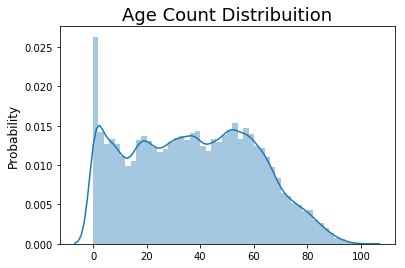

In [22]:
g = sns.distplot(data['Age'])
g.set_title("Age Count Distribuition", fontsize=18)
g.set_xlabel("")
g.set_ylabel("Probability", fontsize=12)

Mean number of appointments per patient:	1.634202330882589
Median number of appointments per patient:	1.0


<function matplotlib.pyplot.show(*args, **kw)>

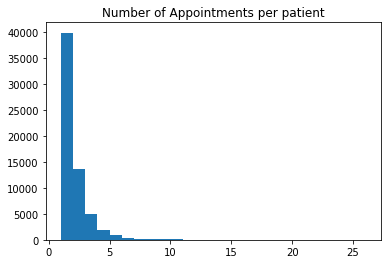

In [23]:
x = data.groupby('PatientId')['AppointmentDay'].nunique()
print('Mean number of appointments per patient:\t%s' %np.mean(x))
print('Median number of appointments per patient:\t%s' %np.median(x))

plt.figure(1)
plt.hist(x, bins = x.nunique())
plt.title("Number of Appointments per patient")
plt.show

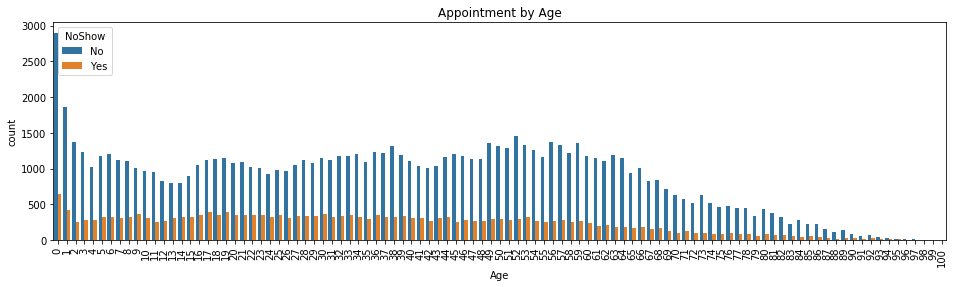

In [24]:
plt.figure(figsize=(16,4))
plt.xticks(rotation=90)
ax  = se.countplot(data['Age'],hue = data['NoShow'])
ax.set_title('Appointment by Age')
plt.show()

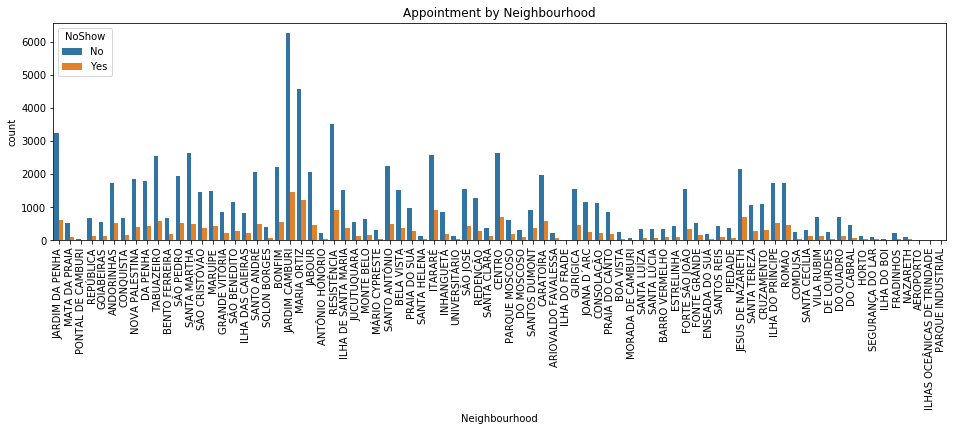

In [25]:
plt.figure(figsize=(16,4))
plt.xticks(rotation=90)
ax  = se.countplot(data['Neighbourhood'],hue = data['NoShow'])
ax.set_title('Appointment by Neighbourhood')
plt.show()

In [26]:
data

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hypertension,Diabetes,Alcoholism,Handicap,SMSReceived,NoShow,ScheduledDay_DOW,AppointmentDay_DOW,Waiting_Time_days
0,29872499824296,5642903,F,2016-04-29,2016-04-29,62,JARDIM DA PENHA,0,1,0,0,0,0,No,Friday,Friday,0
1,558997776694438,5642503,M,2016-04-29,2016-04-29,56,JARDIM DA PENHA,0,0,0,0,0,0,No,Friday,Friday,0
2,4262962299951,5642549,F,2016-04-29,2016-04-29,62,MATA DA PRAIA,0,0,0,0,0,0,No,Friday,Friday,0
3,867951213174,5642828,F,2016-04-29,2016-04-29,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No,Friday,Friday,0
4,8841186448183,5642494,F,2016-04-29,2016-04-29,56,JARDIM DA PENHA,0,1,1,0,0,0,No,Friday,Friday,0
5,95985133231274,5626772,F,2016-04-27,2016-04-29,76,REPÚBLICA,0,1,0,0,0,0,No,Wednesday,Friday,2
6,733688164476661,5630279,F,2016-04-27,2016-04-29,23,GOIABEIRAS,0,0,0,0,0,0,Yes,Wednesday,Friday,2
7,3449833394123,5630575,F,2016-04-27,2016-04-29,39,GOIABEIRAS,0,0,0,0,0,0,Yes,Wednesday,Friday,2
8,56394729949972,5638447,F,2016-04-29,2016-04-29,21,ANDORINHAS,0,0,0,0,0,0,No,Friday,Friday,0
9,78124564369297,5629123,F,2016-04-27,2016-04-29,19,CONQUISTA,0,0,0,0,0,0,No,Wednesday,Friday,2


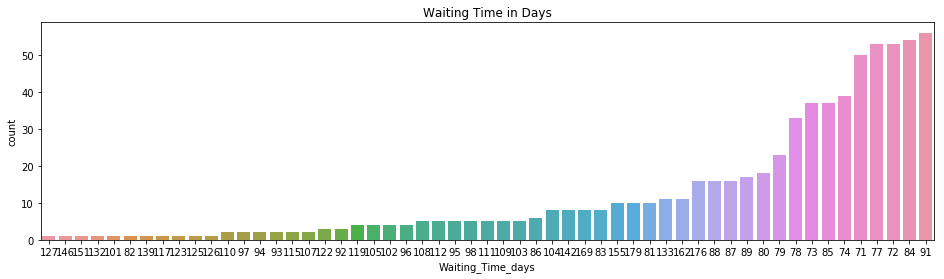

In [27]:
plt.figure(figsize=(16,4))
ax = sns.countplot(x=data.Waiting_Time_days, order=data.Waiting_Time_days.value_counts(ascending=True).iloc[:55].index)
ax.set_title("Waiting Time in Days")
plt.show()

In [28]:
data_viz = data.copy()
bin_ranges = [-1, 2, 8, 16, 18, 25, 40, 50, 60, 75]
bin_names = ["Baby", "Children", "Teenager", 'Young', 'Young-Adult', 'Adult', 'Adult-II', 'Senior', 'Old']

data_viz['age_bin'] = pd.cut(np.array(data_viz['Age']),
                               bins=bin_ranges, labels=bin_names)
# now stack and reset
show_prob_age = pd.crosstab(data_viz['age_bin'], data_viz['NoShow'], normalize='index')

Text(0, 0.5, 'Count')

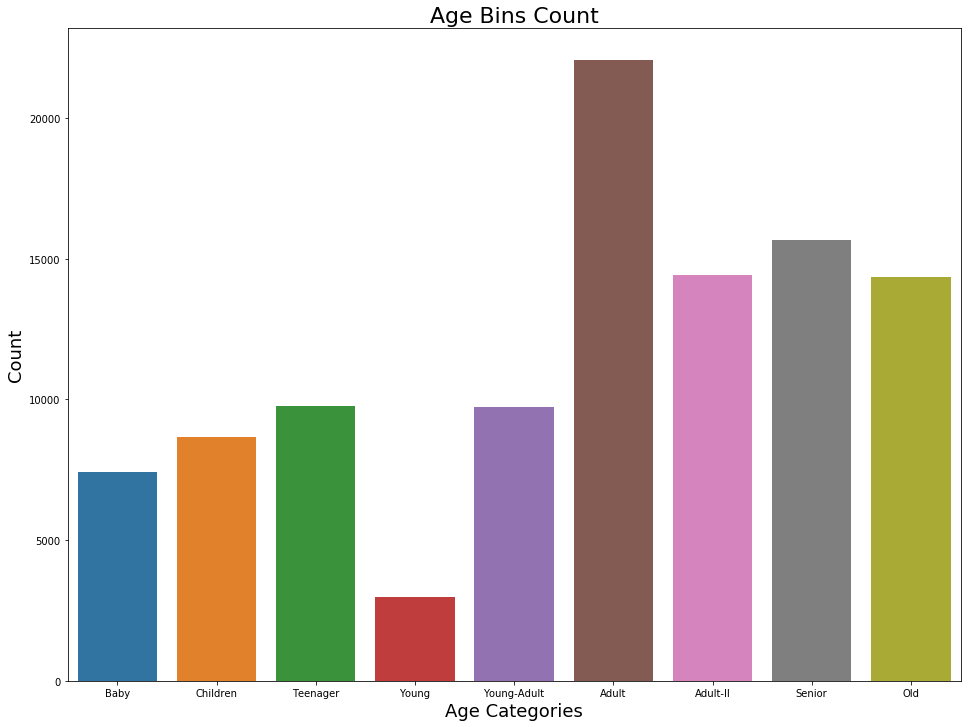

In [29]:
stacked = show_prob_age.unstack().reset_index().rename(columns={0:'value'})
plt.figure(figsize=(16,12))
ax1 = sns.countplot(x="age_bin", data=data_viz)
ax1.set_title("Age Bins Count", fontsize=22)
ax1.set_xlabel("Age Categories", fontsize=18)
ax1.set_ylabel("Count", fontsize=18)

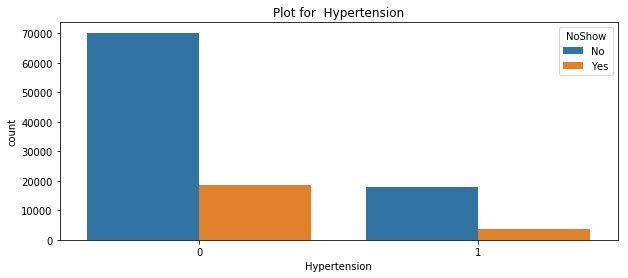

In [30]:
plt.figure(figsize=(10,4))
ax  = se.countplot(data_viz['Hypertension'],hue = data_viz['NoShow'])
ax.set_title('Plot for  Hypertension')
plt.show()

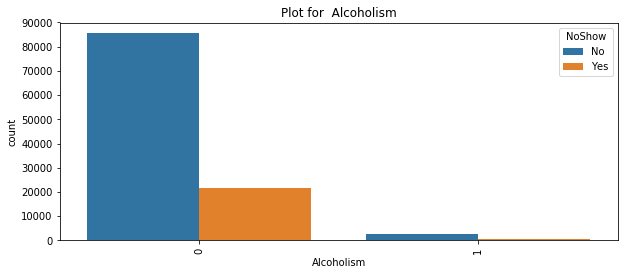

In [31]:
plt.figure(figsize=(10,4))
plt.xticks(rotation=90)
ax  = se.countplot(data_viz['Alcoholism'],hue = data_viz['NoShow'])
ax.set_title('Plot for  Alcoholism')
plt.show()

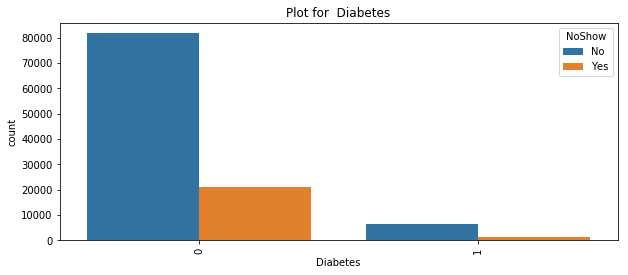

In [32]:
plt.figure(figsize=(10,4))
plt.xticks(rotation=90)
ax  = se.countplot(data_viz['Diabetes'],hue = data_viz['NoShow'])
ax.set_title('Plot for  Diabetes')
plt.show()

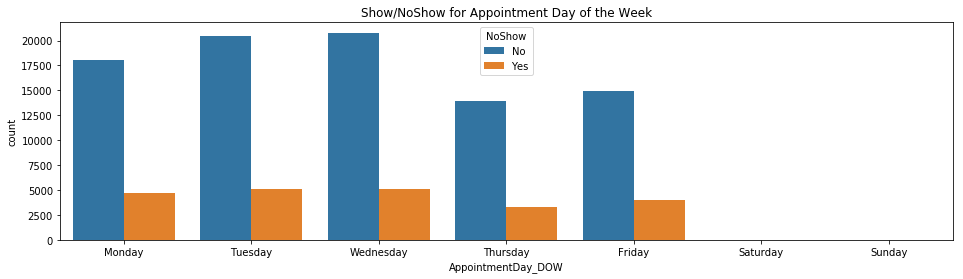

In [33]:
week_key = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
plt.figure(figsize=(16,4))
ax = sns.countplot(x=data_viz.AppointmentDay_DOW, hue=data_viz.NoShow, order=week_key)
ax.set_title("Show/NoShow for Appointment Day of the Week")
plt.show()

### Feature Engineering 

In [34]:
def dayToNumber(day):
    if day == 'Monday': 
        return 0
    if day == 'Tuesday': 
        return 1
    if day == 'Wednesday': 
        return 2
    if day == 'Thursday': 
        return 3
    if day == 'Friday': 
        return 4
    if day == 'Saturday': 
        return 5
    if day == 'Sunday': 
        return 6

data.Gender = data.Gender.apply(lambda x: 1 if x == 'M' else 0)
data.ScheduledDay_DOW = data.ScheduledDay_DOW.apply(dayToNumber)
data.AppointmentDay_DOW = data.AppointmentDay_DOW.apply(dayToNumber)
data.NoShow = data.NoShow.apply(lambda x: 1 if x == 'Yes' else 0)

In [35]:
data['ScheduledDay_Y'] = data['ScheduledDay'].dt.year
data['ScheduledDay_M'] = data['ScheduledDay'].dt.month
data['ScheduledDay_D'] = data['ScheduledDay'].dt.day
data.drop(['ScheduledDay'], axis=1, inplace=True)

data['AppointmentDay_Y'] = data['AppointmentDay'].dt.year
data['AppointmentDay_M'] = data['AppointmentDay'].dt.month
data['AppointmentDay_D'] = data['AppointmentDay'].dt.day
data.drop(['AppointmentDay'], axis=1, inplace=True)

In [36]:
col_to_drop = ['PatientId', 'AppointmentID']
data = data.drop(col_to_drop,axis=1)

In [37]:
le = LabelEncoder()
data['Neighbourhood'] = le.fit_transform(data['Neighbourhood'])

In [39]:
data.columns

Index(['Gender', 'Age', 'Neighbourhood', 'Scholarship', 'Hypertension',
       'Diabetes', 'Alcoholism', 'Handicap', 'SMSReceived', 'NoShow',
       'ScheduledDay_DOW', 'AppointmentDay_DOW', 'Waiting_Time_days',
       'ScheduledDay_Y', 'ScheduledDay_M', 'ScheduledDay_D',
       'AppointmentDay_Y', 'AppointmentDay_M', 'AppointmentDay_D'],
      dtype='object')

### Prediction Models
#### Balancing Dataset using Adasyn
> After performing EDA it has been observed that data is suffering from imbalance.Performing Adasyn for Balancing Target classes


###### How to predict whether or not the patient will show up for an appointment?
 - In order to predict the no-show each analyzed column that has categorical data must be converted to a numerical form; as many machine learning algorithms cannot operate on label data directly. They require all input variables and output variables to be numeric. After transforming the columns that needed changing, the dataset will be split into two subsets:

 - Logistic Regression, K-Nearest Neighbors and Random Forest will be implemented, in order to determine the effectiveness of the models in no-show prediction, f1-tests will be calculated..

In [40]:
data['NoShow'].value_counts(normalize=True) * 100

0    79.807997
1    20.192003
Name: NoShow, dtype: float64

In [41]:
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix

X = data.drop('NoShow',1)
y = data.NoShow

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0)

In [42]:
balancer = ADASYN(random_state=42)
x_resampled, y_resampled = balancer.fit_sample(X_train, y_train)

print('Normal Data: ', Counter(y_train))
print('Resampled: ', Counter(y_resampled))

Normal Data:  Counter({0: 59083, 1: 14964})
Resampled:  Counter({1: 59272, 0: 59083})


In [43]:
scaler = MinMaxScaler(feature_range=(0, 1))
x_resampled = scaler.fit_transform(x_resampled)
X_test = scaler.transform(X_test)

#### Helper functions for Baseline Model

In [44]:
def plot_confusion_matrix(cm, classes,
                          normalize = False,
                          title = 'Confusion matrix"',
                          cmap = plt.cm.Blues) :
    plt.imshow(cm, interpolation = 'nearest', cmap = cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation = 0)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])) :
        plt.text(j, i, cm[i, j],
                 horizontalalignment = 'center',
                 color = 'white' if cm[i, j] > thresh else 'black')

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
# Show metrics 
def show_metrics():
    tp = cm[1,1]
    fn = cm[1,0]
    fp = cm[0,1]
    tn = cm[0,0]
    print('Accuracy  =     {:.3f}'.format((tp+tn)/(tp+tn+fp+fn)))
    print('Precision =     {:.3f}'.format(tp/(tp+fp)))
    print('Recall    =     {:.3f}'.format(tp/(tp+fn)))
    print('F1_score  =     {:.3f}'.format(2*(((tp/(tp+fp))*(tp/(tp+fn)))/
                                                 ((tp/(tp+fp))+(tp/(tp+fn))))))

In [45]:
def plot_precision_recall():
    plt.step(recall, precision, color = 'b', alpha = 0.2,
             where = 'post')
    plt.fill_between(recall, precision, step ='post', alpha = 0.2,
                 color = 'b')

    plt.plot(recall, precision, linewidth=2)
    plt.xlim([0.0,1])
    plt.ylim([0.0,1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision Recall Curve')
    plt.show();


In [46]:
def plot_roc():
    plt.plot(fpr, tpr, label = 'ROC curve', linewidth = 2)
    plt.plot([0,1],[0,1], 'k--', linewidth = 2)
   # plt.xlim([0.0,0.001])
   # plt.ylim([0.0,1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.show();

In [47]:
def plot_learning_curve(estimator, title, X, y, ylim = None, cv = None,
                        n_jobs = 1, train_sizes = np.linspace(.1, 1.0, 5)):
    """
    Plots a learning curve. http://scikit-learn.org/stable/modules/learning_curve.html
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel('Training examples')
    plt.ylabel('Score')
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv = cv, n_jobs = n_jobs, train_sizes = train_sizes)
    train_scores_mean = np.mean(train_scores, axis = 1)
    train_scores_std = np.std(train_scores, axis = 1)
    test_scores_mean = np.mean(test_scores, axis = 1)
    test_scores_std = np.std(test_scores, axis = 1)
    plt.grid()
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha = 0.1, color = "g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color = "r",
             label = "Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color = "g",
             label = "Cross-validation score")
    plt.legend(loc = "best")
    return plt

In [48]:
def cross_val_metrics(model) :
    scores = ['accuracy', 'precision', 'recall']
    for sc in scores:
        scores = cross_val_score(model, X, y, cv = 5, scoring = sc)
        print('[%s] : %0.5f (+/- %0.5f)'%(sc, scores.mean(), scores.std()))

In [49]:
from sklearn.linear_model import LogisticRegression
log_clf = LogisticRegression(random_state = 42)
param_grid = {
            'penalty' : ['l2','l1'],  
            'C' : [0.001, 0.01, 0.1, 1]
            }

CV_log_clf = GridSearchCV(estimator = log_clf, param_grid = param_grid , scoring = 'accuracy', verbose = 1, n_jobs = -1)
CV_log_clf.fit(x_resampled, y_resampled)

best_parameters = CV_log_clf.best_params_
print('The best parameters for using this model is', best_parameters)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    9.3s finished


The best parameters for using this model is {'C': 1, 'penalty': 'l2'}


In [50]:
CV_log2_clf = LogisticRegression(C = best_parameters['C'], 
                                 penalty = best_parameters['penalty'], 
                                 random_state = 42)


CV_log2_clf.fit(x_resampled, y_resampled)

y_pred = CV_log2_clf.predict(X_test)
y_score = CV_log2_clf.decision_function(X_test)
# Confusion maxtrix & metrics
cm = confusion_matrix(y_test, y_pred)
class_names = [0,1]

In [51]:
show_metrics()

Accuracy  =     0.621
Precision =     0.270
Recall    =     0.518
F1_score  =     0.355


In [52]:
cross_val_metrics(CV_log2_clf)

[accuracy] : 0.79214 (+/- 0.01002)
[precision] : 0.36796 (+/- 0.11961)
[recall] : 0.01640 (+/- 0.00547)


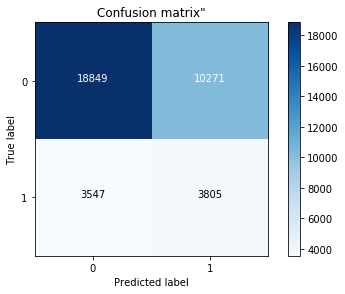

In [53]:
plot_confusion_matrix(cm,classes = class_names)

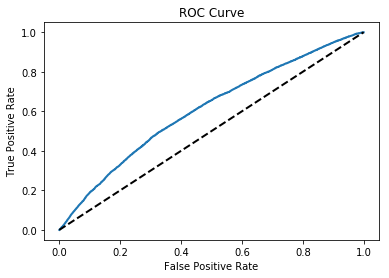

In [54]:
# ROC curve
fpr, tpr, t = roc_curve(y_test, y_score)
plot_roc()

### Model Selection

In [55]:
clfs = []
seed = 3

clfs.append(("LogReg", 
             Pipeline([("Scaler", StandardScaler()),
                       ("LogReg", LogisticRegression())])))

clfs.append(("XGBClassifier",
             Pipeline([("Scaler", StandardScaler()),
                       ("XGB", XGBClassifier())]))) 
clfs.append(("KNN", 
             Pipeline([("Scaler", StandardScaler()),
                       ("KNN", KNeighborsClassifier())]))) 

clfs.append(("DecisionTreeClassifier", 
             Pipeline([("Scaler", StandardScaler()),
                       ("DecisionTrees", DecisionTreeClassifier())]))) 

clfs.append(("RandomForestClassifier", 
             Pipeline([("Scaler", StandardScaler()),
                       ("RandomForest", RandomForestClassifier())]))) 

clfs.append(("GradientBoostingClassifier", 
             Pipeline([("Scaler", StandardScaler()),
                       ("GradientBoosting", GradientBoostingClassifier(max_features=15, 
                                                                       n_estimators=600))]))) 

clfs.append(("RidgeClassifier", 
             Pipeline([("Scaler", StandardScaler()),
                       ("RidgeClassifier", RidgeClassifier())])))


clfs.append(("ExtraTreesClassifier",
             Pipeline([("Scaler", StandardScaler()),
                       ("ExtraTrees", ExtraTreeClassifier())])))

scoring = 'accuracy'
n_folds = 10
msgs = []
results, names  = [], [] 

for name, model  in clfs:
    kfold = KFold(n_splits=n_folds, random_state=seed)
    cv_results = cross_val_score(model, x_resampled, y_resampled, 
                                 cv=kfold, scoring=scoring, n_jobs=-1)    
    names.append(name)
    results.append(cv_results)    
    msg = "%s: %f (+/- %f)" % (name, cv_results.mean(),  
                               cv_results.std())
    msgs.append(msg)
    print(msg)


LogReg: 0.630391 (+/- 0.013375)
XGBClassifier: 0.791139 (+/- 0.057268)
KNN: 0.739100 (+/- 0.038383)
DecisionTreeClassifier: 0.787371 (+/- 0.074166)
RandomForestClassifier: 0.831391 (+/- 0.070415)
GradientBoostingClassifier: 0.765504 (+/- 0.048362)
RidgeClassifier: 0.572337 (+/- 0.018233)
ExtraTreesClassifier: 0.778423 (+/- 0.063920)


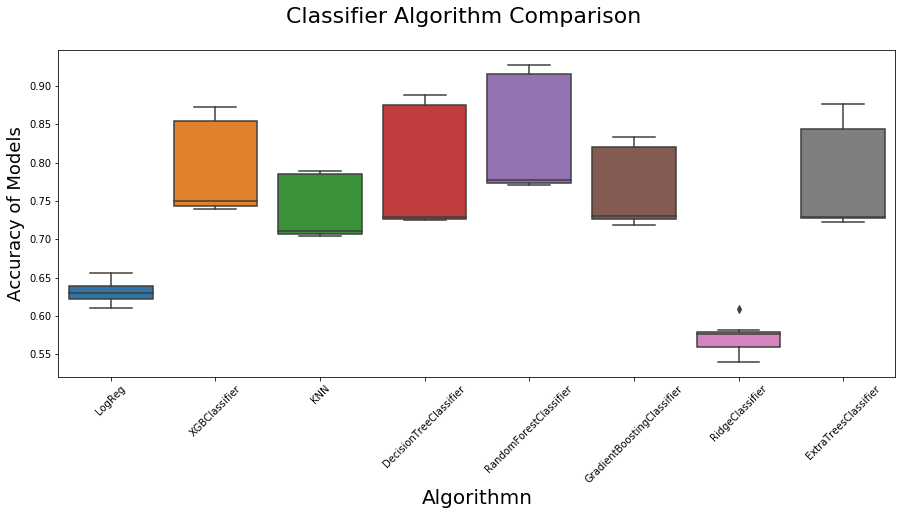

In [56]:
# boxplot algorithm comparison
fig = plt.figure(figsize=(15,6))
fig.suptitle('Classifier Algorithm Comparison', fontsize=22)
ax = fig.add_subplot(111)
sns.boxplot(x=names, y=results)
ax.set_xticklabels(names)
ax.set_xlabel("Algorithmn", fontsize=20)
ax.set_ylabel("Accuracy of Models", fontsize=18)
ax.set_xticklabels(ax.get_xticklabels(),rotation=45)
plt.show()

### Hyper parameter tuning using Grid Search

In [ ]:
rf_clf = RandomForestClassifier(random_state = 42)
param_grid = {"n_estimators": [100, 200, 300],
              "max_depth": [3, 5,8],
              "min_samples_split": [15, 20],
              "min_samples_leaf": [5, 10, 20],
              "max_leaf_nodes": [20, 40],
              "min_weight_fraction_leaf": [0.1]}
CV_log_rf = GridSearchCV(estimator = rf_clf, param_grid = param_grid , scoring = 'accuracy', verbose = 1, n_jobs = -1)
CV_log_rf.fit(x_resampled, y_resampled)

best_parameters = CV_log_rf.best_params_
print('The best parameters for using this model is', best_parameters)

Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  8.7min
[Parallel(n_jobs=-1)]: Done 540 out of 540 | elapsed: 33.7min finished


The best parameters for using this model is {'max_depth': 8, 'max_leaf_nodes': 20, 'min_samples_leaf': 5, 'min_samples_split': 15, 'min_weight_fraction_leaf': 0.1, 'n_estimators': 200}


Training accuracy : 0.682556714967682
Testing accuarcy : 0.5888626891862251
RF: ROC AUC=0.688
              precision    recall  f1-score   support

           0       0.90      0.55      0.68     29120
           1       0.29      0.75      0.42      7352

    accuracy                           0.59     36472
   macro avg       0.60      0.65      0.55     36472
weighted avg       0.77      0.59      0.63     36472



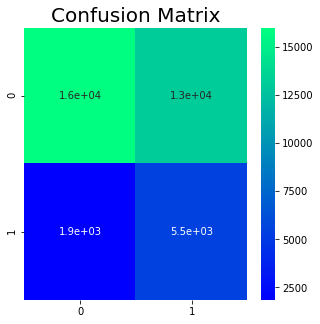

In [ ]:
# creating a model
model = RandomForestClassifier(max_depth = 3,max_leaf_nodes =20,min_samples_leaf=5,min_samples_split=15,min_weight_fraction_leaf=0.1,n_estimators=200)

# feeding the training set into the model
model.fit(x_resampled, y_resampled)

# predicting the test set results
y_pred = model.predict(X_test)

# predict probabilities
ns_probs = [0 for _ in range(len(y_test))]
rf_probs = model.predict_proba(X_test)
# keep probabilities for the positive outcome only
rf_probs = rf_probs[:, 1]
# calculate scores
rf_probs = roc_auc_score(y_test, rf_probs)
# summarize scores
# Calculating the accuracies
print("Training accuracy :", model.score(x_resampled, y_resampled))
print("Testing accuarcy :", model.score(X_test, y_test))
print('RF: ROC AUC=%.3f' % (rf_probs))

# classification report
cr = classification_report(y_test, y_pred)
print(cr)

# confusion matrix 
cm = confusion_matrix(y_test, y_pred)
plt.rcParams['figure.figsize'] = (5, 5)
se.heatmap(cm, annot = True, cmap = 'winter')
plt.title('Confusion Matrix', fontsize = 20)
plt.show()

### Experimenting with ANNs

In [113]:
model = Sequential()
model.add(Dense(64,input_dim = 18,activation='relu'))
model.add(Dense(32,activation='relu',init = 'uniform'))
model.add(Dense(16,activation='relu',init = 'uniform'))
model.add(Dense(1,activation = 'sigmoid'))
model.summary()




_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 64)                1216      
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_3 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 17        
Total params: 3,841
Trainable params: 3,841
Non-trainable params: 0
_________________________________________________________________


In [114]:
model.compile(loss = 'binary_crossentropy',optimizer='adam',metrics=['accuracy'])
#es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=2)
history=model.fit(x_resampled,y_resampled ,epochs=50,batch_size=128, validation_data=(X_test,y_test))



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Train on 118355 samples, validate on 36472 samples
Epoch 1/50
118355/118355 [==============================] - 3s 26us/step - loss: 0.6085 - acc: 0.6576 - val_loss: 0.5484 - val_acc: 0.7241
Epoch 2/50
118355/118355 [==============================] - 2s 17us/step - loss: 0.5279 - acc: 0.7142 - val_loss: 0.5429 - val_acc: 0.7276
Epoch 3/50
118355/118355 [==============================] - 2s 17us/step - loss: 0.5052 - acc: 0.7256 - val_loss: 0.5356 - val_acc: 0.7217
Epoch 4/50
118355/118355 [==============================] - 2s 17us/step - loss: 0.4935 - acc: 0.7303 - val_loss: 0.5093 - val_acc: 0.7475
Epoch 5/50
118355/118355 [==============================] - 2s 17us/step - loss: 0.4848 - acc: 0.7359 - val_loss: 0.5173 - val_acc: 0.7462
Epoch 6/50
118355/118355 [==============================] - 2s 17us/step - loss: 0.4797 - acc: 0.7385 - val_loss: 0.5193 - val_acc: 0.7301
Epoch 7/50
118355/

In [115]:
# evaluate the keras model
_, accuracy = model.evaluate(x_resampled, y_resampled)
print('Accuracy: %.2f' % (accuracy*100))

118355/118355 [==============================] - 2s 18us/step
Accuracy: 75.91


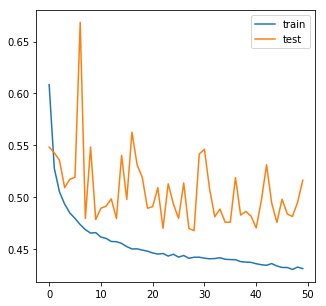

In [116]:
from matplotlib import pyplot
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

## END